<a href="https://colab.research.google.com/github/KTH-EXPECA/summer-school-2025/blob/main/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scipy

Download the datasets:

In [4]:
!mkdir -p /content/data
!curl -L -o /content/data/dataset.zip "https://github.com/KTH-EXPECA/summer-school-2025/raw/refs/heads/main/dataset.zip"
!unzip -q -o /content/data/dataset.zip
!rm -rf /content/data
!rm -rf /content/__MACOSX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20.5M  100 20.5M    0     0  12.6M      0  0:00:01  0:00:01 --:--:-- 40.8M


Import required packages:

In [5]:
import pickle, json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [6]:
pkl_path = Path("/content/dataset.pkl")
with open(pkl_path, "rb") as f:
    datasets = pickle.load(f)

for i, item in enumerate(datasets, 1):
    df = pd.DataFrame(item.get("dataset"))
    meta = {k: v for k, v in item.items() if k != "dataset"}

    print(f"\n===== ITEM {i} =====")
    print("META:", meta)
    print(f"DATASET: DataFrame shape={df.shape}, columns:{df.columns}")


===== ITEM 1 =====
META: {'db_id': 0, 'dataset_name': 'e20', 'stream_rnti': '77e2', 'size': 90306, 'arrivals_num': 18061}
DATASET: DataFrame shape=(90306, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len',
       'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols',
       'time_since_start', 'time_since_last_event'],
      dtype='object')

===== ITEM 2 =====
META: {'db_id': 1, 'dataset_name': 'e4', 'stream_rnti': 'a431', 'size': 146421, 'arrivals_num': 36602}
DATASET: DataFrame shape=(146421, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_timestamp', 'slot', 'len',
       'mcs_index', 'mretx', 'rfailed', 'num_rbs', 'num_symbols',
       'time_since_start', 'time_since_last_event'],
      dtype='object')

===== ITEM 3 =====
META: {'db_id': 2, 'dataset_name': 'e19', 'stream_rnti': '37ff', 'size': 89016, 'arrivals_num': 18058}
DATASET: DataFrame shape=(89016, 13), columns:Index(['segment', 'packet_id', 'timestamp', 'depart_

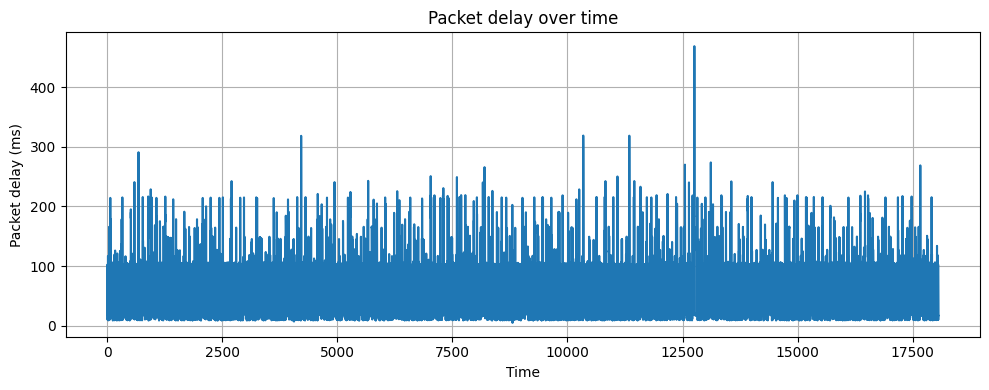

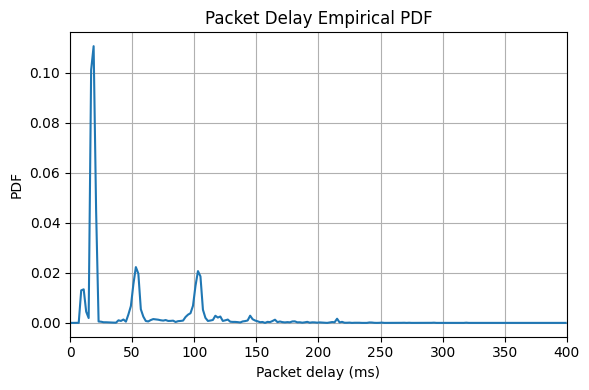

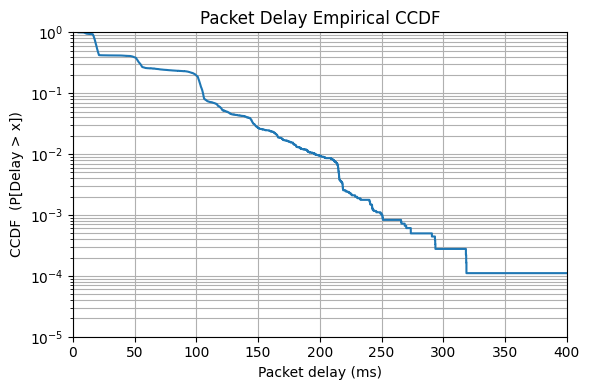

In [7]:
df = pd.DataFrame(datasets[0]['dataset'])
df = df.loc[df['segment'] == -1].copy()

df['packet_delay_ms'] = (df['depart_timestamp'].astype(float) - df['timestamp'].astype(float)) * 1000
packet_delays_ms = df['packet_delay_ms'].tolist()

plt.figure(figsize=(10, 4))
plt.plot(df['packet_delay_ms'].values)
plt.xlabel('Time')
plt.ylabel('Packet delay (ms)')
plt.title('Packet delay over time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Use the same delays column you computed
delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()

# Keep only [0, 400] ms for the plot domain
mask = (delays >= 0) & (delays <= 400)
delays_clip = delays[mask]

# Histogram as PDF (area = 1). 2 ms bins across 0–400 ms -> 200 bins
bins = np.linspace(0, 400, 201)
pdf_vals, bin_edges = np.histogram(delays_clip, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, pdf_vals)
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('PDF')
plt.title('Packet Delay Empirical PDF')
plt.grid(True)
plt.tight_layout()
plt.show()

# calculate CCDF
delays = pd.to_numeric(df['packet_delay_ms'], errors='coerce').dropna().to_numpy()
delays.sort()                              # ascending
n = delays.size
ccdf = 1.0 - (np.arange(1, n + 1) / n)     # empirical CCDF = 1 - ECDF

# plot CCDF
plt.figure(figsize=(6, 4))
plt.step(delays, ccdf, where='post')       # survival curve style
plt.yscale('log')
plt.xlim(0, 400)
plt.ylim(1e-5, 1)
plt.xlabel('Packet delay (ms)')
plt.ylabel('CCDF  (P[Delay > x])')
plt.title('Packet Delay Empirical CCDF')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()




In [8]:
!pip install tensorflow
!pip install keras

In [23]:
import h5py
import keras
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

from typing import Tuple

import keras
import numpy as np
import numpy.typing as npt
import tensorflow as tf
from keras import layers

def create_model_inputs(feature_names, dtype=tf.float32):
    inputs = {}
    for feature_name in feature_names:
        inputs[feature_name] = layers.Input(
            name=feature_name,
            shape=(1,),
            dtype=dtype,
        )
    return inputs

def squeeze_generic(a, axes_to_keep):
    out_s = [s for i, s in enumerate(a.shape) if i in axes_to_keep or s != 1]
    return a.reshape(out_s)

class MLP:
    def __init__(
        self,
        bayesian,
        batch_size,
        feature_names: list,  # list(str)
        name: str = "mlp",
        output_layer_config: dict = None,
        dtype=tf.dtypes.float64,
        hidden_sizes=(16, 16),
        hidden_activation="tanh",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform",  # 'zeros'
        dropout_ph=None,
        loaded_mlp_model: keras.Model = None,
    ):
        """
        :param dropout_ph: None if no dropout should be used. Else a scalar placeholder that determines the prob of dropping a node.
        Remember to set placeholder to Zero during test / eval
        """

        if loaded_mlp_model is not None:
            # set the model
            self._model = loaded_mlp_model

            # find the input layer and slices
            self._input_layer = self._model.get_layer("input")
            # find slice layer names
            slice_names = []
            int_node = self._input_layer._inbound_nodes[0]

            # figure out inbound_layers size
            tmp = np.array([int_node.inbound_layers])
            tmp = np.transpose(tmp)
            tmp = squeeze_generic(tmp, [0])
            if len(tmp) > 1:
                # more than one input layer
                for idx, layer in enumerate(int_node.inbound_layers):
                    slice_names.append(layer.name)
            else:
                # only one input layer
                slice_names.append(int_node.inbound_layers.name)

            # create input slices by concatenating slices
            self._input_slices = {}
            for slice_name in slice_names:
                self._input_slices[slice_name] = self._model.get_layer(slice_name).input

            # find the output layer and slices
            self._output_layer = self._model.get_layer("output")
            # find slice layer names
            slice_names = []
            int_node = self._output_layer._inbound_nodes[0]
            for idx, layer in enumerate(int_node.inbound_layers):
                slice_names.append(layer.name)
            # create output layer by concatenating slices
            self._output_slices = {}
            for slice_name in slice_names:
                self._output_slices[slice_name] = self._model.get_layer(
                    slice_name
                ).output

        else:

            # Using functional API of keras instead of sequential
            self._input_slices = create_model_inputs(feature_names,dtype=dtype)
            if len(feature_names) == 1:
                self._input_layer = layers.Dense(
                    1, activation=None, use_bias=False, name="input"
                )(list(self._input_slices.values())[0])
            else:
                self._input_layer = keras.layers.concatenate(
                    list(self._input_slices.values()), name="input"
                )

            # features = layers.BatchNormalization()(features)

            for idx, hidden_size in enumerate(hidden_sizes):
                if idx == 0:
                    prev_layer = self._input_layer

                # create the new hidden layer
                hidden_layer = layers.Dense(
                    name="hidden_%d" % idx,
                    units=hidden_size,
                    activation=hidden_activation,
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    dtype=dtype,
                )

                # connect the new layer
                prev_layer = hidden_layer(prev_layer)

                # create and connect the dropout layer
                if dropout_ph is not None:
                    dropout_layer = layers.Dropout(dropout_ph)
                    prev_layer = dropout_layer(prev_layer)

            # create output layer by concatenating slices
            self._output_slices = {}
            slices = []
            for slice_name in output_layer_config:
                slice_dense = layers.Dense(
                    name=slice_name,
                    units=output_layer_config[slice_name]["slice_size"],
                    activation=output_layer_config[slice_name]["slice_activation"],
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    dtype=dtype,
                )
                self._output_slices[slice_name] = slice_dense(prev_layer)
                slices.append(self._output_slices[slice_name])

            # connect output layer
            self._output_layer = layers.Concatenate(name="output")(slices)
            # print(self._output_layer)

            # create model
            self._model = keras.Model(
                inputs=self._input_slices, outputs=self._output_layer, name=name
            )
            # self._model.summary()

    @property
    def input_layer(self):
        return self._input_layer

    @property
    def input_slices(self):
        return self._input_slices

    @property
    def output_slices(self):
        return self._output_slices

    @property
    def model(self):
        return self._model


# Single Layer Perceptron
class SLP:
    def __init__(
        self,
        bayesian,
        batch_size,
        name: str = "slp",
        layer_config: dict = None,
        dtype=tf.dtypes.float64,
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform",  # 'zeros' VERY IMPORTANT! Otherwise all components would be the same
        loaded_slp_model: keras.Model = None,
    ):
        """
        Remember to set placeholder to Zero during test / eval
        """

        if loaded_slp_model is not None:
            # set the model
            self._model = loaded_slp_model

            # find the input and output layers
            self._input_layer = self._model.input
            self._output_layer = self._model.get_layer("output")

            # find slice layer names
            slice_names = []
            int_node = self._output_layer._inbound_nodes[0]
            for idx, layer in enumerate(int_node.inbound_layers):
                slice_names.append(layer.name)

            # create output layer by concatenating slices
            self._output_slices = {}
            for slice_name in slice_names:
                self._output_slices[slice_name] = self._model.get_layer(
                    slice_name
                ).output

        else:

            # Using functional API of keras

            # This is just a dummy input
            self._input_layer = keras.Input(
                name="dummy_input",
                shape=(1,), # Changed from shape=(1) to shape=(1,)
                batch_size=batch_size,
                dtype=dtype,
            )

            # create the single layer by concatenating slices
            self._output_slices = {}
            slices = []
            for slice_name in layer_config:
                slice_dense = layers.Dense(
                    name=slice_name,
                    units=layer_config[slice_name]["slice_size"],
                    activation=layer_config[slice_name]["slice_activation"],
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    dtype=dtype,
                )
                self._output_slices[slice_name] = slice_dense(self._input_layer)
                slices.append(self._output_slices[slice_name])

            # connect output layer
            self._output_layer = layers.Concatenate(name="output")(slices)
            # print(self._output_layer)

            # create model
            self._model = keras.Model(
                inputs=self._input_layer, outputs=self._output_layer, name=name
            )
            # self._model.summary()

    @property
    def input_layer(self):
        return self._input_layer

    @property
    def output_slices(self):
        return self._output_slices

    @property
    def model(self):
        return self._model



class DensityEstimator:
    def __init__(
        self,
        h5_addr: str = None,
        bayesian: bool = False,
        batch_size: int = None,
        dtype: str = "float64",
    ):
        self._bayesian = bayesian
        self._batch_size = batch_size

        # configure keras to use dtype
        tf.keras.backend.set_floatx(dtype)

        # for creating the tensors
        if dtype == "float64":
            self._dtype = tf.float64
        elif dtype == "float32":
            self._dtype = tf.float32
        elif dtype == "float16":
            self._dtype = tf.float16
        else:
            raise Exception("unknown dtype format")

    def create_core(self, h5_addr: str):
        pass

    def save(self, h5_addr: str):
        pass

    def create_models(self):
        pass

    def prob_single(self):
        pass

    def prob_batch(self):
        pass

    def sample_n(self):
        pass

    def get_parameters(self):
        pass

    def fit(self):
        pass

    @property
    def prob_pred_model(self) -> keras.Model:
        return self._prob_pred_model

    @property
    def sample_model(self) -> keras.Model:
        return self._sample_model

    @property
    def params_model(self) -> keras.Model:
        return self._params_model

    @property
    def training_model(self) -> keras.Model:
        return self._training_model

    @property
    def pl_training_model(self) -> keras.Model:
        return self._pl_training_model

    @property
    def params_config(self) -> dict:
        return self._params_config

    @property
    def core_model(self):
        return self._core_model

    @property
    def loss(self):
        return self._loss

    @property
    def bayesian(self):
        return self._bayesian

    @property
    def batch_size(self):
        return self._batch_size

    @property
    def dtype(self):
        return self._dtype


class NonConditionalDensityEstimator(DensityEstimator):
    def create_core(self, h5_addr: str):

        # initiate the slp model
        if h5_addr is not None:
            # load the keras model and feed to SLP
            self._core_model = SLP(
                loaded_slp_model=keras.models.load_model(
                    h5_addr,
                ),
                bayesian=self.bayesian,
                batch_size=self.batch_size,
            )

        else:
            # create SLP model
            self._core_model = SLP(
                name="slp_keras_model",
                bayesian=self.bayesian,
                batch_size=self.batch_size,
                layer_config=self.params_config,
                dtype=self.dtype,
            )

    def prob_single(self, y: np.float64) -> Tuple[np.float64, np.float64, np.float64]:

        # for single value x (not batch)
        # y : np.float64 number
        x = 0
        [pdf, log_pdf, ecdf] = self.prob_pred_model.predict(
            [np.expand_dims(x, axis=0), np.expand_dims(y, axis=0)],
        )
        return np.squeeze(pdf), np.squeeze(log_pdf), np.squeeze(ecdf)

    def prob_batch(
        self,
        y: npt.NDArray[np.float64],
        batch_size=32,
        verbose=0,
        steps=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
    ):

        # for large batches of input y
        # y : np.array of np.float64 with the shape (batch_size,1) e.g. np.array([5,6,7,8,9,10])
        x = np.zeros(len(y))

        # IMPORTANT: batch size by default in keras is set to 32, if data length is 32*k+1, it raises error.
        if len(y) > batch_size:
            if len(y) % batch_size == 1:
                batch_size = batch_size * 2

        [pdf, log_pdf, ecdf] = self.prob_pred_model.predict(
            [x, y],
            batch_size=len(y),
            verbose=verbose,
            steps=steps,
            callbacks=None,
            max_queue_size=max_queue_size,
            workers=workers,
            use_multiprocessing=use_multiprocessing,
        )
        return np.squeeze(pdf), np.squeeze(log_pdf), np.squeeze(ecdf)

    def sample_n(
        self,
        n: int,
        random_generator: np.random.Generator = np.random.default_rng(),
        batch_size=None,
        verbose=0,
        steps=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False,
    ) -> npt.NDArray[np.float64]:

        # generate n random numbers uniformly distributed on [0,1]
        x = np.zeros(n)
        y = random_generator.uniform(0, 1, n)

        samples = self.sample_model.predict(
            [x, y],
            batch_size=batch_size,
            verbose=verbose,
            steps=steps,
            callbacks=None,
            max_queue_size=max_queue_size,
            workers=workers,
            use_multiprocessing=use_multiprocessing,
        )
        return np.squeeze(samples)

    def get_parameters(self) -> dict:

        # for single value x (not batch)
        # y : np.float64 number
        x = 0
        # for single value x (not batch)
        # x : np.array of np.float64 with the shape (ndim)
        prediction_res = self.params_model.predict(np.expand_dims(x, axis=0))

        result_dict = {}
        for idx, param in enumerate(self.params_config):
            result_dict[param] = np.squeeze(prediction_res[idx])

        return result_dict

    def fit(
        self,
        Y,
        optimizer,
        batch_size: int = 1000,
        epochs: int = 10,
    ):

        # this keras model is the one that we use for training
        # self.core_model.model.compile(optimizer=optimizer, loss=self.loss)
        self.training_model.compile(optimizer=optimizer, loss=self.loss)

        X = np.zeros(len(Y))
        # history = self.core_model.model.fit(
        self.training_model.fit(
            x=[X, Y],
            y=Y,
            batch_size=batch_size,
            epochs=epochs,
            # We pass some validation for
            # monitoring validation loss and metrics
            # at the end of each epoch
            # validation_data=(x_val, y_val),
        )

    def fit_pipeline(
        self,
        train_dataset,
        test_dataset,
        optimizer,
        batch_size: int = 1000,
        epochs: int = 10,
    ):

        # this keras model is the one that we use for training
        # self.core_model.model.compile(optimizer=optimizer, loss=self.loss)
        self.pl_training_model.compile(optimizer=optimizer, loss=self.loss)

        # In this train_dataset, there must be an all zero column

        # history = self.core_model.model.fit(
        self.pl_training_model.fit(
            train_dataset,
            batch_size=batch_size,
            epochs=epochs,
            # We pass some validation for
            # monitoring validation loss and metrics
            # at the end of each epoch
            validation_data=test_dataset,
            # metrics=[keras.metrics.KLDivergence()]
        )



class GaussianMM(NonConditionalDensityEstimator):
    def __init__(
        self,
        centers: int = 8,
        h5_addr: str = None,
        batch_size: int = None,
        dtype: str = "float64",
    ):

        super(GaussianMM, self).__init__(
            h5_addr=h5_addr,
            batch_size=batch_size,
            dtype=dtype,
        )

        # figure out parameters
        if h5_addr is not None:
            # read side parameters
            with h5py.File(h5_addr, "r") as hf:
                self._centers = int(hf.get("centers")[0])

                if "y_mean" in hf and "y_std" in hf:
                    self._y_mean = float(hf["y_mean"][0])
                    self._y_std  = float(hf["y_std"][0])

                if "batch_size" in hf.keys():
                    self._batch_size = int(hf.get("batch_size")[0])

        else:
            self._centers = centers
            self._batch_size = batch_size

        # create parameters dict
        self._params_config = {
            "mixture_weights": {
                "slice_size": self.centers,
                "slice_activation": "softmax",
            },
            "mixture_locations": {
                "slice_size": self.centers,
                "slice_activation": None,
            },
            "mixture_scales": {
                "slice_size": self.centers,
                "slice_activation": "softplus",
            },
        }

        # ask NonConditionalDensityEstimator to form the SLP
        self.create_core(h5_addr=h5_addr)
        # self._core_model.model.summary()

        # create models for inference:
        # self._prob_pred_model, self._sample_model, self._params_model, self._training_model
        self.create_models()

    def save(self, h5_addr: str) -> None:
        self.core_model.model.save(h5_addr)
        with h5py.File(h5_addr, "a") as hf:
            hf.create_dataset("y_mean", data=np.array([y_mean], dtype=np.float64))
            hf.create_dataset("y_std",  data=np.array([y_std],  dtype=np.float64))
            hf.create_dataset("centers", shape=(1,), data=int(self.centers))
            if self.batch_size is not None:
                hf.create_dataset("batch_size", shape=(1,), data=int(self.batch_size))

    def create_models(self):
        # --- inputs & params ---
        self.dummy_input = self.core_model.input_layer  # shape (None,1)
        self.weights = self.core_model.output_slices["mixture_weights"]  # (None, C)
        self.locs    = self.core_model.output_slices["mixture_locations"]  # (None, C)
        self.scales  = self.core_model.output_slices["mixture_scales"]     # (None, C)

        # params model (unchanged)
        self._params_model = keras.Model(
            inputs=self.dummy_input,
            outputs=[self.weights, self.locs, self.scales],
            name="params_model",
        )

        # y input: use tuple shape
        self.y_input = keras.Input(
            name="y_input",
            shape=(1,),                    # <-- FIX: (1,)
            batch_size=self.batch_size,
            dtype=self.dtype,
        )
        # flatten to scalar per example for TFP
        y_flat = layers.Lambda(lambda y: tf.squeeze(y, axis=-1), name="y_flat")(self.y_input)

        # Small helper building the distribution inside a Keras Lambda
        def _mk_mix(args):
            w, m, s = args
            mix = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=w),  # dtype defaults to int32 internally
                components_distribution=tfd.Normal(loc=m, scale=s),
            )
            return mix

        # We compute pdf/logpdf/cdf via Lambdas so Keras accepts it
        def _pdf(args):
            w, m, s, y = args
            mix = _mk_mix([w, m, s])
            return mix.prob(y)  # (None,)

        def _logpdf(args):
            w, m, s, y = args
            mix = _mk_mix([w, m, s])
            return mix.log_prob(y)  # (None,)

        def _cdf(args):
            w, m, s, y = args
            mix = _mk_mix([w, m, s])
            return mix.cdf(y)  # (None,)

        pdf     = layers.Lambda(_pdf,    name="pdf")    ([self.weights, self.locs, self.scales, y_flat])
        log_pdf = layers.Lambda(_logpdf, name="log_pdf")([self.weights, self.locs, self.scales, y_flat])
        ecdf    = layers.Lambda(_cdf,    name="ecdf")   ([self.weights, self.locs, self.scales, y_flat])

        # expand dims back to (None,1) like you had
        self.pdf     = layers.Lambda(lambda z: tf.expand_dims(z, -1))(pdf)
        self.log_pdf = layers.Lambda(lambda z: tf.expand_dims(z, -1))(log_pdf)
        self.ecdf    = layers.Lambda(lambda z: tf.expand_dims(z, -1))(ecdf)

        # models you use downstream
        self._prob_pred_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.pdf, self.log_pdf, self.ecdf],
            name="prob_pred_model",
        )

        self._pl_training_model = keras.Model(
            inputs={"dummy_input": self.dummy_input, "y_input": self.y_input},
            outputs=[self.log_pdf],
            name="pl_training_model",
        )

        self._training_model = keras.Model(
            inputs=[self.dummy_input, self.y_input],
            outputs=[self.log_pdf],
            name="training_model",
        )

        # loss: negative mean log-likelihood (keeps your signature)
        class CustomLossLayer(tf.keras.layers.Layer):
            def __init__(self, idtype=tf.float64, **kwargs):
                super().__init__(**kwargs)
                self.idtype = idtype
            def call(self, inputs):
                y_true, y_pred = inputs
                # y_pred is (batch,1); take mean over batch
                return -tf.reduce_mean(y_pred)

        self._loss = lambda y_true, y_pred: CustomLossLayer(self.dtype)([y_true, y_pred])

    @property
    def centers(self):
        return self._centers

In [38]:
model = GaussianMM(centers=16)
batch_size = 32

X = None
Y = np.asarray(delays, dtype=np.float64).reshape(-1, 1)
y_mean = float(Y.mean())
y_std  = float(Y.std() + 1e-8)   # avoid divide-by-zero
Yz = (Y - y_mean) / y_std

training_rounds = [
    {"learning_rate": 0.001, "epochs": 64}
]

# Ensure shapes are (N,1)
Xz = np.zeros((len(Yz), 1))
Yz = np.asarray(Yz).reshape(-1, 1)

# pick 1000 random indices without replacement
n_samples = 1000
idx = np.random.choice(len(Yz), size=n_samples, replace=False)

X_sub = Xz[idx]
Y_sub = Yz[idx]

for i, rp in enumerate(training_rounds, 1):
    print(f"Training session {i}/{len(training_rounds)} with {rp}")
    model.training_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=rp["learning_rate"]),
        loss=model.loss,
    )
    model.training_model.fit(
        x=[Xz, Yz],
        y=Yz,
        batch_size=batch_size,   # <— use this, not steps_per_epoch
        epochs=rp["epochs"],
        verbose=1,               # <— see logs
        shuffle=True,
    )



Training session 1/1 with {'learning_rate': 0.001, 'epochs': 64}
Epoch 1/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4430
Epoch 2/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0302
Epoch 3/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6218
Epoch 4/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3638
Epoch 5/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1670
Epoch 6/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0057
Epoch 7/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.0396
Epoch 8/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.1033
Epoch 9/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.0848
Epoch 10/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.1152
Epoch 11/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.0985
Epoch 12/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: -0.0995
Epoch 13/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: -0.1205
Epoch 14/64
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

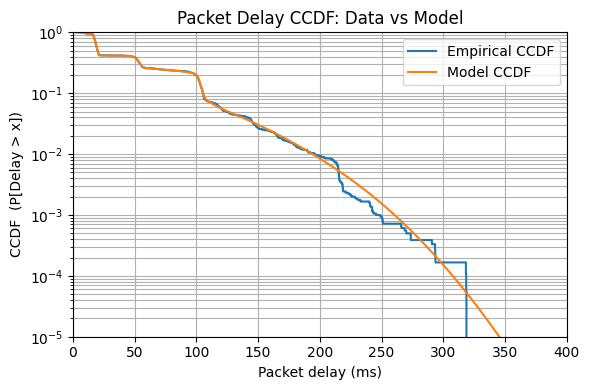

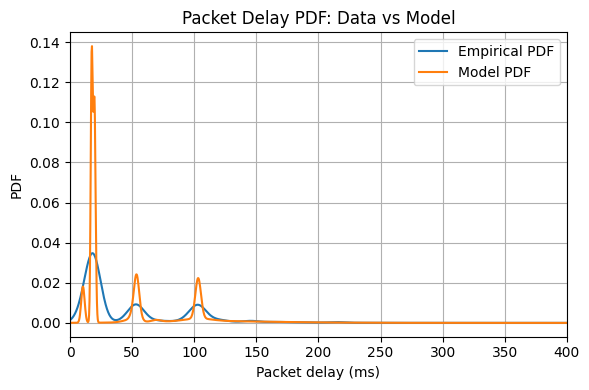

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_ccdf_pdf_with_model(
    delays_ms: np.ndarray,
    model,
    max_x: float = 400.0,
    num_points: int = 1200,
    batch_size: int = 2048,
    y_mean: float | None = None,
    y_std: float | None = None,
    pdf_bins: int = 80,
    use_kde: bool = True,
):
    """
    delays_ms : 1D array of delays (ms)
    model     : your GaussianMM instance (with .prob_pred_model)
    y_mean,y_std : if you trained on standardized targets, pass them here
    """

    # ----- Clean & sort data -----
    delays = pd.to_numeric(pd.Series(delays_ms), errors='coerce').dropna().to_numpy(float)
    delays = delays[(delays >= 0) & (delays <= max_x)]
    delays.sort()
    n = delays.size
    if n == 0:
        raise ValueError("No valid delay samples in range.")

    # ----- Empirical CCDF -----
    emp_ccdf = 1.0 - (np.arange(1, n + 1) / n)

    # ----- Grid for model curves -----
    grid_y = np.linspace(0.0, max_x, num_points)

    # If trained on z, feed z into the model
    if (y_mean is not None) and (y_std is not None):
        z = (grid_y - y_mean) / (y_std + 1e-12)
        jac = 1.0 / (y_std + 1e-12)  # for PDF only
    else:
        z = grid_y
        jac = 1.0

    # dtype & shapes for model inputs
    try:
        dtype_np = getattr(model, "dtype").as_numpy_dtype
    except Exception:
        dtype_np = np.float64

    X_dummy = np.zeros_like(z, dtype=dtype_np).reshape(-1, 1)
    Y_in    = np.asarray(z, dtype=dtype_np).reshape(-1, 1)

    # Predict model pdf/logpdf/ecdf
    pdf_m, logpdf_m, ecdf_m = model.prob_pred_model.predict(
        [X_dummy, Y_in], batch_size=batch_size, verbose=0
    )
    pdf_m   = np.squeeze(pdf_m)   * jac         # scale pdf if standardized
    ccdf_m  = 1.0 - np.squeeze(ecdf_m)         # ccdf unaffected by affine scale

    # ----- Empirical PDF (KDE or histogram density) -----
    # Try KDE for smooth curve; fallback to histogram
    emp_x_pdf = None
    emp_pdf   = None
    if use_kde:
        try:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(delays)
            emp_x_pdf = grid_y
            emp_pdf   = kde(emp_x_pdf)
        except Exception:
            pass

    if emp_pdf is None:
        # Histogram density estimate
        counts, edges = np.histogram(delays, bins=pdf_bins, range=(0, max_x), density=True)
        emp_x_pdf = 0.5 * (edges[:-1] + edges[1:])
        emp_pdf   = counts

    # ===================== PLOTS =====================

    # CCDF
    plt.figure(figsize=(6, 4))
    plt.step(delays, emp_ccdf, where='post', label='Empirical CCDF')
    plt.plot(grid_y, ccdf_m, label='Model CCDF')
    plt.yscale('log')
    plt.xlim(0, max_x)
    plt.ylim(1e-5, 1)
    plt.xlabel('Packet delay (ms)')
    plt.ylabel('CCDF  (P[Delay > x])')
    plt.title('Packet Delay CCDF: Data vs Model')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PDF
    plt.figure(figsize=(6, 4))
    # empirical (step if hist; line if KDE)
    if len(emp_x_pdf) == len(grid_y):
        plt.plot(emp_x_pdf, emp_pdf, label='Empirical PDF')
    else:
        plt.step(emp_x_pdf, emp_pdf, where='mid', label='Empirical PDF')
    # model
    plt.plot(grid_y, pdf_m, label='Model PDF')
    plt.xlim(0, max_x)
    plt.xlabel('Packet delay (ms)')
    plt.ylabel('PDF')
    plt.title('Packet Delay PDF: Data vs Model')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Empirical delays array you already computed
# delays = df['packet_delay_ms'].to_numpy()

# If you trained on raw ms:
#plot_ccdf_pdf_with_model(delays_ms=delays, model=model, max_x=400)

# If you trained on standardized targets:
plot_ccdf_pdf_with_model(delays, model, 400, y_mean=y_mean, y_std=y_std)


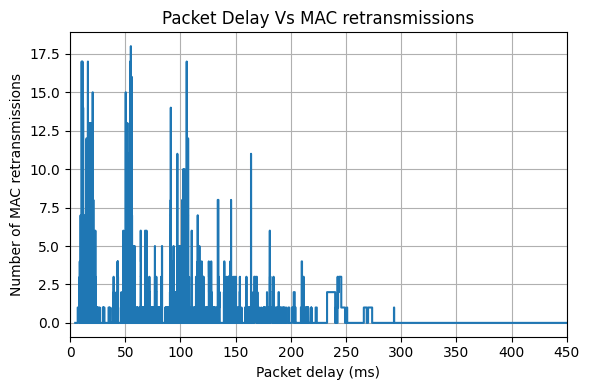

In [ ]:
# Get the no of mac retransmissions
mretx = df['mretx'].tolist()

# plot delay distribution over the number of mac retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, mretx, where='post')       # survival curve style
plt.xlim(0, 450)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of MAC retransmissions')
plt.title('Packet Delay Vs MAC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

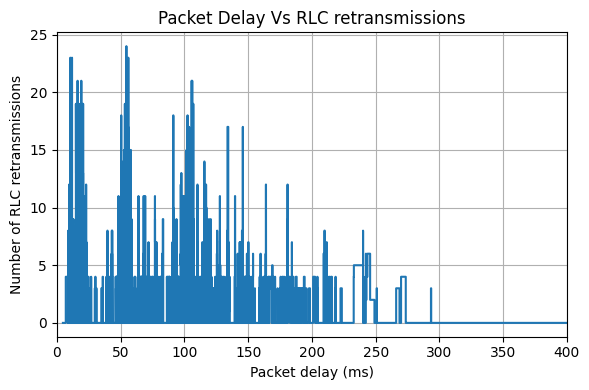

In [ ]:
# Get the no of rlc retransmissions
rlcRetx = df['rfailed'].tolist()

# plot delay distribution over the number of rlc retransmissions
plt.figure(figsize=(6, 4))
plt.step(delays, rlcRetx, where='post')       # survival curve style
plt.xlim(0, 400)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Number of RLC retransmissions')
plt.title('Packet Delay Vs RLC retransmissions')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

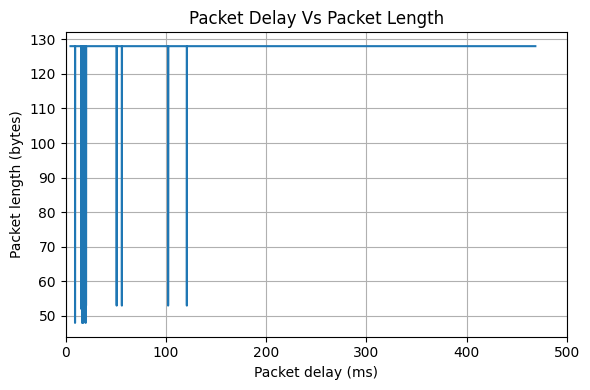

In [ ]:
# Get the packet length
pktLen = df['len'].tolist()

# plot delay distribution over the packet length
plt.figure(figsize=(6, 4))
plt.step(delays, pktLen, where='post')       # survival curve style
plt.xlim(0, 500)
plt.xlabel('Packet delay (ms)')
plt.ylabel('Packet length (bytes)')
plt.title('Packet Delay Vs Packet Length')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()